In [1]:
import os
import keras
import random

2022-07-06 11:57:18.328275: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2022-07-06 11:57:18.332934: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-07-06 11:57:18.332946: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [2]:
classes = {0: "falaise" , 1: "batiment", 2:"route",3:"pierrier",4:"verger",
            5:"champ",6:"prairie",7:"foret",8:"foret_claire",9:"buisson",10:"eau"}

In [3]:
import numpy as np
import tensorflow as tf
from keras import backend as K
import matplotlib.pyplot as plt
import segmentation_models as sm
from utils import visualize, freeze_session
from data_loader import Dataset, Dataloader
from keras.backend import set_session
from augmentation import *

Segmentation Models: using `keras` framework.


In [4]:
# Tensorflow session
config = tf.compat.v1.ConfigProto()
config.gpu_options.allow_growth = True  # dynamically grow the memory used on the GPU
config.log_device_placement = False  # to log device placement (on which device the operation ran)
sess = tf.compat.v1.Session(config=config)
set_session(sess)  # set this TensorFlow session as the default session for Keras

train_dir = "Synthese/Train/"
test_dir = "Synthese/Valid/"
result_dir = "Synthese2/Result/"
image_size = 512
image_channels = 3
padding_size = 800
n_classes = 11

# model parameters
BACKBONE = 'efficientnetb3'
BATCH_SIZE = 8
LR = 0.001
EPOCHS = 100
activation ='softmax'

2022-07-06 11:57:25.450879: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-07-06 11:57:25.542689: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/hugo/new_ampli/env/lib/python3.9/site-packages/cv2/../../lib64:
2022-07-06 11:57:25.542776: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublas.so.11'; dlerror: libcublas.so.11: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/hugo/new_ampli/env/lib/python3.9/site-packages/cv2/../../lib64:
2022-0

In [5]:
if not os.path.exists(result_dir):
    os.mkdir(result_dir)
    
x_train_dir = os.path.join(train_dir, 'images')
y_train_dir = os.path.join(train_dir, 'masks')
x_valid_dir = os.path.join(test_dir, 'images')
y_valid_dir = os.path.join(test_dir, 'masks')


# define network parameters 
preprocess_input = sm.get_preprocessing(BACKBONE)

# Dataset for train images
train_dataset = Dataset(
    x_train_dir, 
    y_train_dir, 
    classes=n_classes, 
    augmentation=False,
    preprocessing=get_preprocessing(preprocess_input),
    #preprocessing=False,
)

# Dataset for validation images
valid_dataset = Dataset(
    x_valid_dir, 
    y_valid_dir, 
    classes=n_classes, 
    augmentation=False,
    preprocessing=get_preprocessing(preprocess_input),
    #preprocessing=False,
)

/home/hugo/new_ampli/env/lib/python3.9/site-packages/albumentations/augmentations/transforms.py:2029: UserWarning: Using lambda is incompatible with multiprocessing. Consider using regular functions or partial().
  warnings.warn('Using lambda is incompatible with multiprocessing. '


In [6]:
#create model
model = sm.Unet(BACKBONE,classes=n_classes, activation=activation)

# define optomizer
optim = keras.optimizers.Adam(LR)

# Segmentation models losses can be combined together by '+' and scaled by integer or float factor
dice_loss = sm.losses.DiceLoss(class_weights=np.ones(n_classes)) 
focal_loss = sm.losses.CategoricalFocalLoss()
total_loss = dice_loss + (1 * focal_loss)

metrics = [sm.metrics.IOUScore(threshold=0.5), sm.metrics.FScore(threshold=0.5)]

# compile keras model with defined optimozer, loss and metrics
model.compile(optim, total_loss, metrics)

2022-07-06 11:57:34.755831: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1850] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


In [8]:
BATCH_SIZE = 8
#Dataloaders
train_dataloader = Dataloader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
valid_dataloader = Dataloader(valid_dataset, batch_size=1, shuffle=False)

# check shapes for errors
assert train_dataloader[0][0].shape == (BATCH_SIZE, image_size, image_size, image_channels)
assert train_dataloader[0][1].shape == (BATCH_SIZE, image_size, image_size, n_classes)


In [9]:
# define callbacks for learning rate scheduling and best checkpoints saving
callbacks = [
    keras.callbacks.ModelCheckpoint(os.path.join(result_dir,'best_model.h5'), save_weights_only=True, save_best_only=True, mode='min'),
    keras.callbacks.ReduceLROnPlateau(),
]

# train model
history = model.fit(
    train_dataloader, 
    steps_per_epoch=len(train_dataloader), 
    epochs=EPOCHS, 
    callbacks=callbacks, 
    validation_data=valid_dataloader, 
    validation_steps=len(valid_dataloader),
)

Epoch 1/100
51/51 [==============================] - 442s 8s/step - loss: 0.7166 - iou_score: 0.3203 - f1-score: 0.3851 - val_loss: 0.9006 - val_iou_score: 0.4405 - val_f1-score: 0.4708 - lr: 0.0010
Epoch 2/100
51/51 [==============================] - 414s 8s/step - loss: 0.4651 - iou_score: 0.5549 - f1-score: 0.6261 - val_loss: 0.8545 - val_iou_score: 0.4662 - val_f1-score: 0.5003 - lr: 0.0010
Epoch 3/100
51/51 [==============================] - 403s 8s/step - loss: 0.3838 - iou_score: 0.5985 - f1-score: 0.6601 - val_loss: 0.7849 - val_iou_score: 0.5200 - val_f1-score: 0.5530 - lr: 0.0010
Epoch 4/100
51/51 [==============================] - 404s 8s/step - loss: 0.3363 - iou_score: 0.6362 - f1-score: 0.7081 - val_loss: 0.7851 - val_iou_score: 0.4966 - val_f1-score: 0.5315 - lr: 0.0010
Epoch 5/100
51/51 [==============================] - 407s 8s/step - loss: 0.2930 - iou_score: 0.6826 - f1-score: 0.7511 - val_loss: 0.7092 - val_iou_score: 0.5530 - val_f1-score: 0.5791 - lr: 0.0010
Epoch

51/51 [==============================] - 394s 8s/step - loss: 0.1392 - iou_score: 0.8431 - f1-score: 0.8760 - val_loss: 0.6373 - val_iou_score: 0.6250 - val_f1-score: 0.6505 - lr: 0.0010
Epoch 43/100
51/51 [==============================] - 394s 8s/step - loss: 0.1666 - iou_score: 0.8002 - f1-score: 0.8427 - val_loss: 0.6705 - val_iou_score: 0.6141 - val_f1-score: 0.6443 - lr: 0.0010
Epoch 44/100
51/51 [==============================] - 391s 8s/step - loss: 0.1525 - iou_score: 0.8201 - f1-score: 0.8573 - val_loss: 0.6429 - val_iou_score: 0.6779 - val_f1-score: 0.7041 - lr: 0.0010
Epoch 45/100
51/51 [==============================] - 391s 8s/step - loss: 0.1261 - iou_score: 0.8661 - f1-score: 0.8928 - val_loss: 0.6268 - val_iou_score: 0.7363 - val_f1-score: 0.7596 - lr: 0.0010
Epoch 46/100
51/51 [==============================] - 397s 8s/step - loss: 0.1218 - iou_score: 0.8716 - f1-score: 0.8967 - val_loss: 0.6154 - val_iou_score: 0.7298 - val_f1-score: 0.7533 - lr: 0.0010
Epoch 47/100


51/51 [==============================] - 397s 8s/step - loss: 0.1576 - iou_score: 0.8101 - f1-score: 0.8518 - val_loss: 0.6866 - val_iou_score: 0.5762 - val_f1-score: 0.6102 - lr: 0.0010
Epoch 84/100
51/51 [==============================] - 396s 8s/step - loss: 0.1339 - iou_score: 0.8414 - f1-score: 0.8751 - val_loss: 0.6277 - val_iou_score: 0.6826 - val_f1-score: 0.7104 - lr: 0.0010
Epoch 85/100
51/51 [==============================] - 395s 8s/step - loss: 0.1292 - iou_score: 0.8499 - f1-score: 0.8810 - val_loss: 0.6246 - val_iou_score: 0.6477 - val_f1-score: 0.6766 - lr: 0.0010
Epoch 86/100
51/51 [==============================] - 395s 8s/step - loss: 0.1235 - iou_score: 0.8525 - f1-score: 0.8837 - val_loss: 0.6365 - val_iou_score: 0.6548 - val_f1-score: 0.6884 - lr: 0.0010
Epoch 87/100
51/51 [==============================] - 399s 8s/step - loss: 0.1128 - iou_score: 0.8669 - f1-score: 0.8928 - val_loss: 0.6013 - val_iou_score: 0.7287 - val_f1-score: 0.7532 - lr: 0.0010
Epoch 88/100


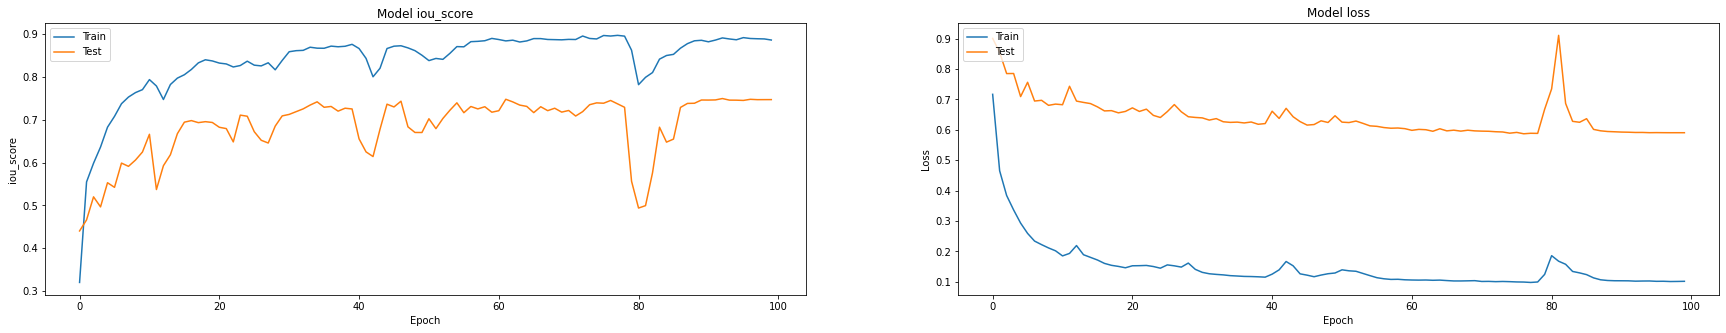

In [10]:
# Plot training & validation iou_score values
plt.figure(figsize=(30, 5))
plt.subplot(121)
plt.plot(history.history['iou_score'])
plt.plot(history.history['val_iou_score'])
plt.title('Model iou_score')
plt.ylabel('iou_score')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')

# Plot training & validation loss values
plt.subplot(122)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.savefig(os.path.join(result_dir,'UNET-Training.png'))
plt.show()

#Save model as Tensorflow frozen graph
#frozen_graph = freeze_session(K.get_session(),output_names=[out.op.name for out in model.outputs])
#tf.train.write_graph(frozen_graph, result_dir , "best_model.pb", as_text=False)

In [20]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 3898084235310497015
xla_global_id: -1
]


2022-06-28 09:37:59.083168: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1850] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


In [9]:
model.load_weights(os.path.join(result_dir,'best_model.h5'))

In [10]:
valid_imgs=[]
valid_labels=[]

for img,label in valid_dataset:
    valid_imgs.append(img)
    valid_labels.append(label)
    
valid_imgs = np.array(valid_imgs)
valid_labels = np.array(valid_labels)

In [11]:
predictions = model.predict(valid_imgs)

6/6 [==============================] - 47s 7s/step


In [12]:
true_label = np.argmax(valid_labels,axis=3)
label_pred = np.argmax(predictions,axis=3)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


139


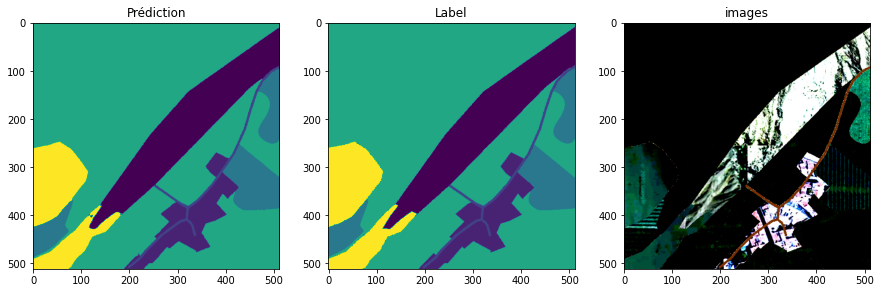

In [13]:
i=random.choice(range(len(valid_imgs)-1))
print(i)

plt.figure(figsize=(15, 5))
plt.subplot(131)
plt.imshow(label_pred[i])
plt.gca().set_title("Prédiction")

plt.subplot(132)
plt.imshow(true_label[i])
plt.gca().set_title("Label")

plt.subplot(133)
plt.imshow(valid_imgs[i])
plt.gca().set_title("images")
plt.show()

### Avec seuil

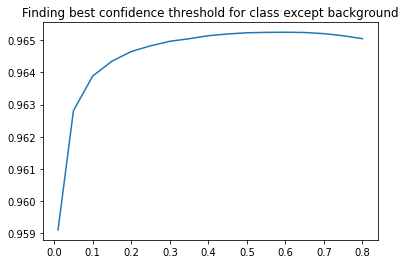

In [15]:
ious = []
threshold_iou = [0.01,0.05,0.1,0.15,0.2,
                 0.25,0.3,0.35,0.4,0.45,0.5,
                 0.55,0.6,0.65,0.7,0.75,0.8]

for threshold in threshold_iou:
    iou = []
    for idx_classe in range(1,11):
        prediction = np.where(predictions[...,idx_classe]<= threshold,0,1)
        target = valid_labels[...,idx_classe]

        intersection = np.logical_and(target,prediction)
        union = np.logical_or(target,prediction)
        iou_score = np.sum(intersection) / np.sum(union)

        # print("iou score for class", classes[idx_classe], ": with 0.5 threshold ",iou_score)
        iou.append(iou_score)
    ious.append(np.mean(iou))
    
plt.plot(threshold_iou,ious)
plt.gca().set_title("Finding best confidence threshold for class except background")
plt.show()

In [21]:
best_threshold = 0.5

In [ ]:
conf_mat = np.zeros((11,11))

for idx_pred_class in range(11):
    for idx_target_class in range(11):
        prediction = np.where(predictions[...,idx_pred_class]<= best_threshold,0,1)
        target = valid_labels[...,idx_target_class]

        intersection = np.logical_and(target,prediction)
        conf_mat[idx_pred_class,idx_target_class] = np.sum(intersection)

In [ ]:
(np.sum(conf_mat.flatten()) - len(valid_imgs)*SIZE[0]*SIZE[1]) / 

### Avec l'Argmax

In [16]:
prediction = np.zeros(predictions.shape)

for idx_class in range(11):
    prediction[...,idx_class][label_pred == idx_class] = 1

In [17]:
iou = []
for idx_classe in range(11):
    target = valid_labels[...,idx_classe]

    intersection = np.logical_and(target,prediction[...,idx_classe])
    union = np.logical_or(target,prediction[...,idx_classe])
    iou_score = np.sum(intersection) / np.sum(union)

    iou.append(iou_score)
print(iou)
    
print("mIou: ", np.mean(iou))

[0.9087439484247658, 0.9865813108765968, 0.974124103248564, 0.6589008448114928, 0.9902723305468434, 0.9794567240939586, 0.9912283647294998, 0.9865668836216421, 0.9640276010608962, 0.9452783884345332, 0.9782708758521864]
mIou:  0.9421319432455436


In [17]:
conf_mat = np.zeros((11,11))

for idx_pred_class in range(11):
    for idx_target_class in range(11):
        target = valid_labels[...,idx_target_class]

        intersection = np.logical_and(target,prediction[...,idx_pred_class])
        conf_mat[idx_pred_class,idx_target_class] = np.sum(intersection)

In [18]:
classe = list(classes.values())

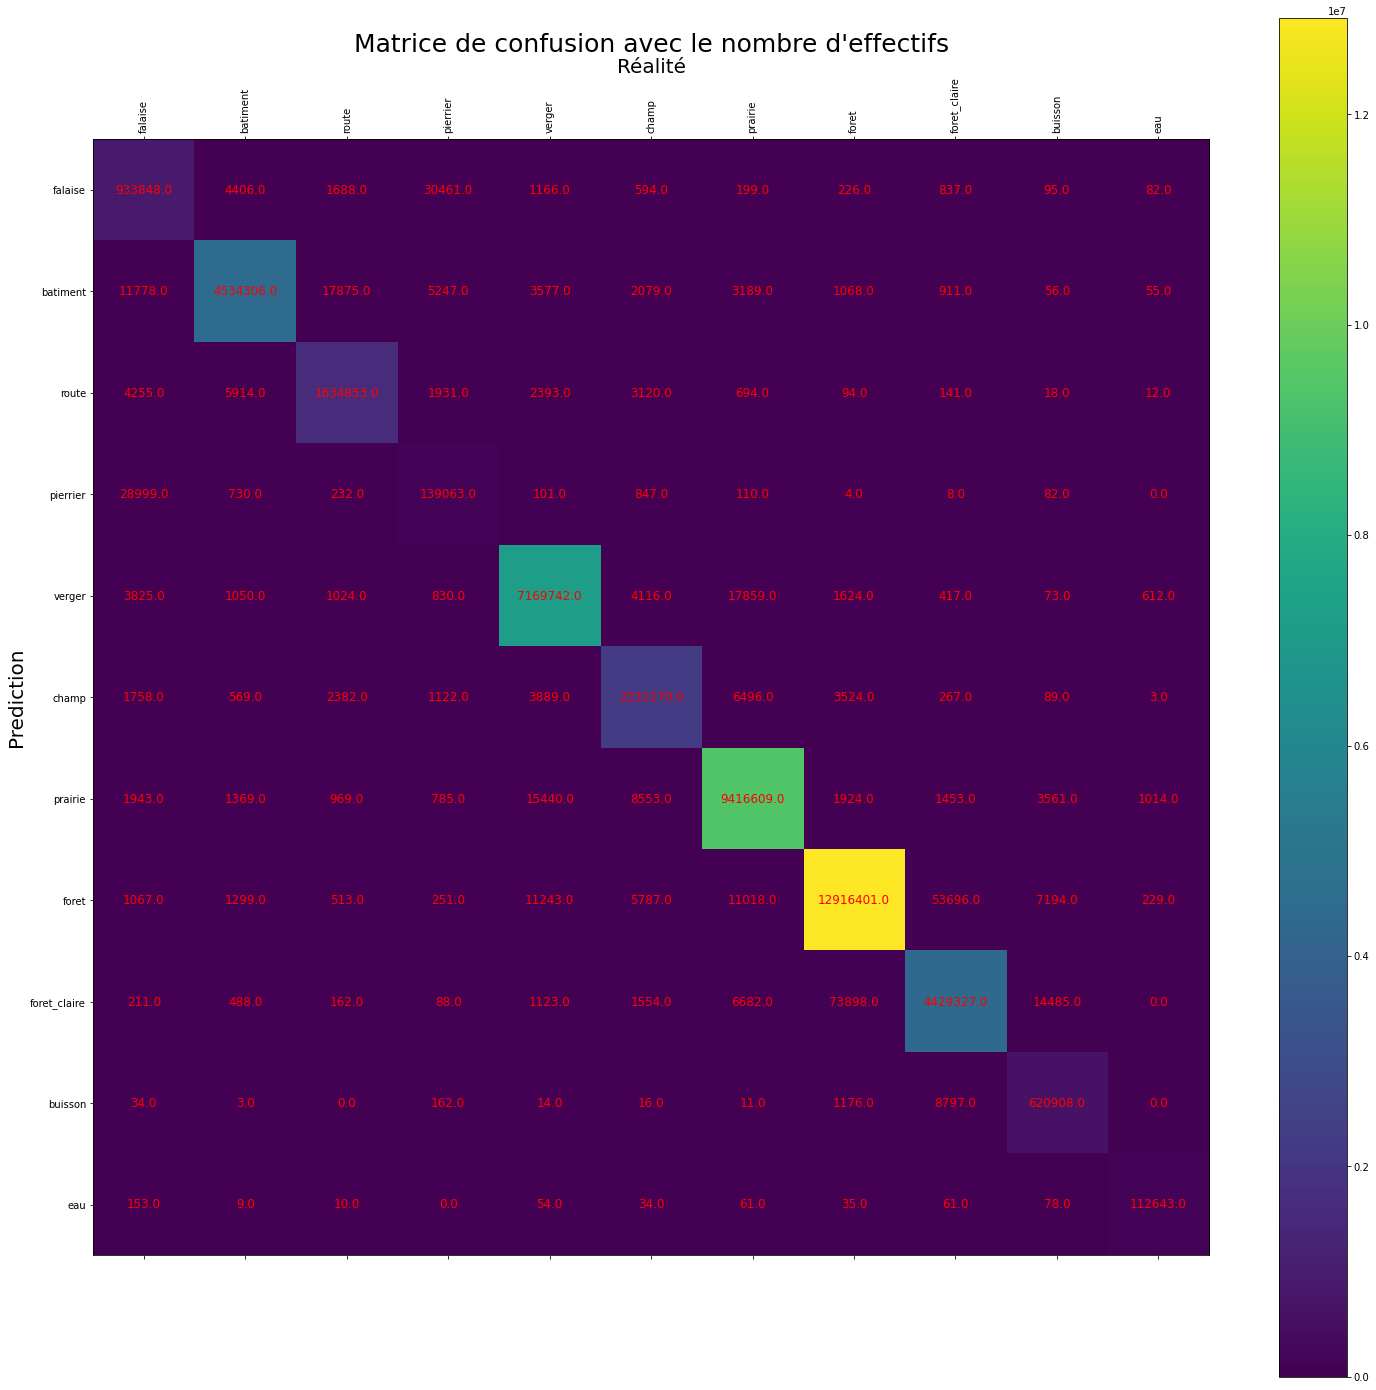

In [19]:
data = conf_mat

fig = plt.figure(figsize=(25,25))
ax = fig.add_subplot(111)
cax = ax.matshow(data, interpolation='nearest')
fig.colorbar(cax)

for i in range(len(data)):
    for j in range(len(data)):
        c = data[j,i]
        ax.text(i, j, str(round(c,2)), va='center', ha='center',
                color="red",size = "large")
        
plt.xticks(range(11), classe, rotation='vertical')
plt.yticks(range(11), classe, rotation='horizontal')
plt.xlabel('Réalité', fontsize=20)
plt.gca().xaxis.set_label_position('top') 
plt.ylabel('Prediction', fontsize=20)
plt.gca().set_title("Matrice de confusion avec le nombre d'effectifs", fontsize=25)
plt.show()
plt.show()

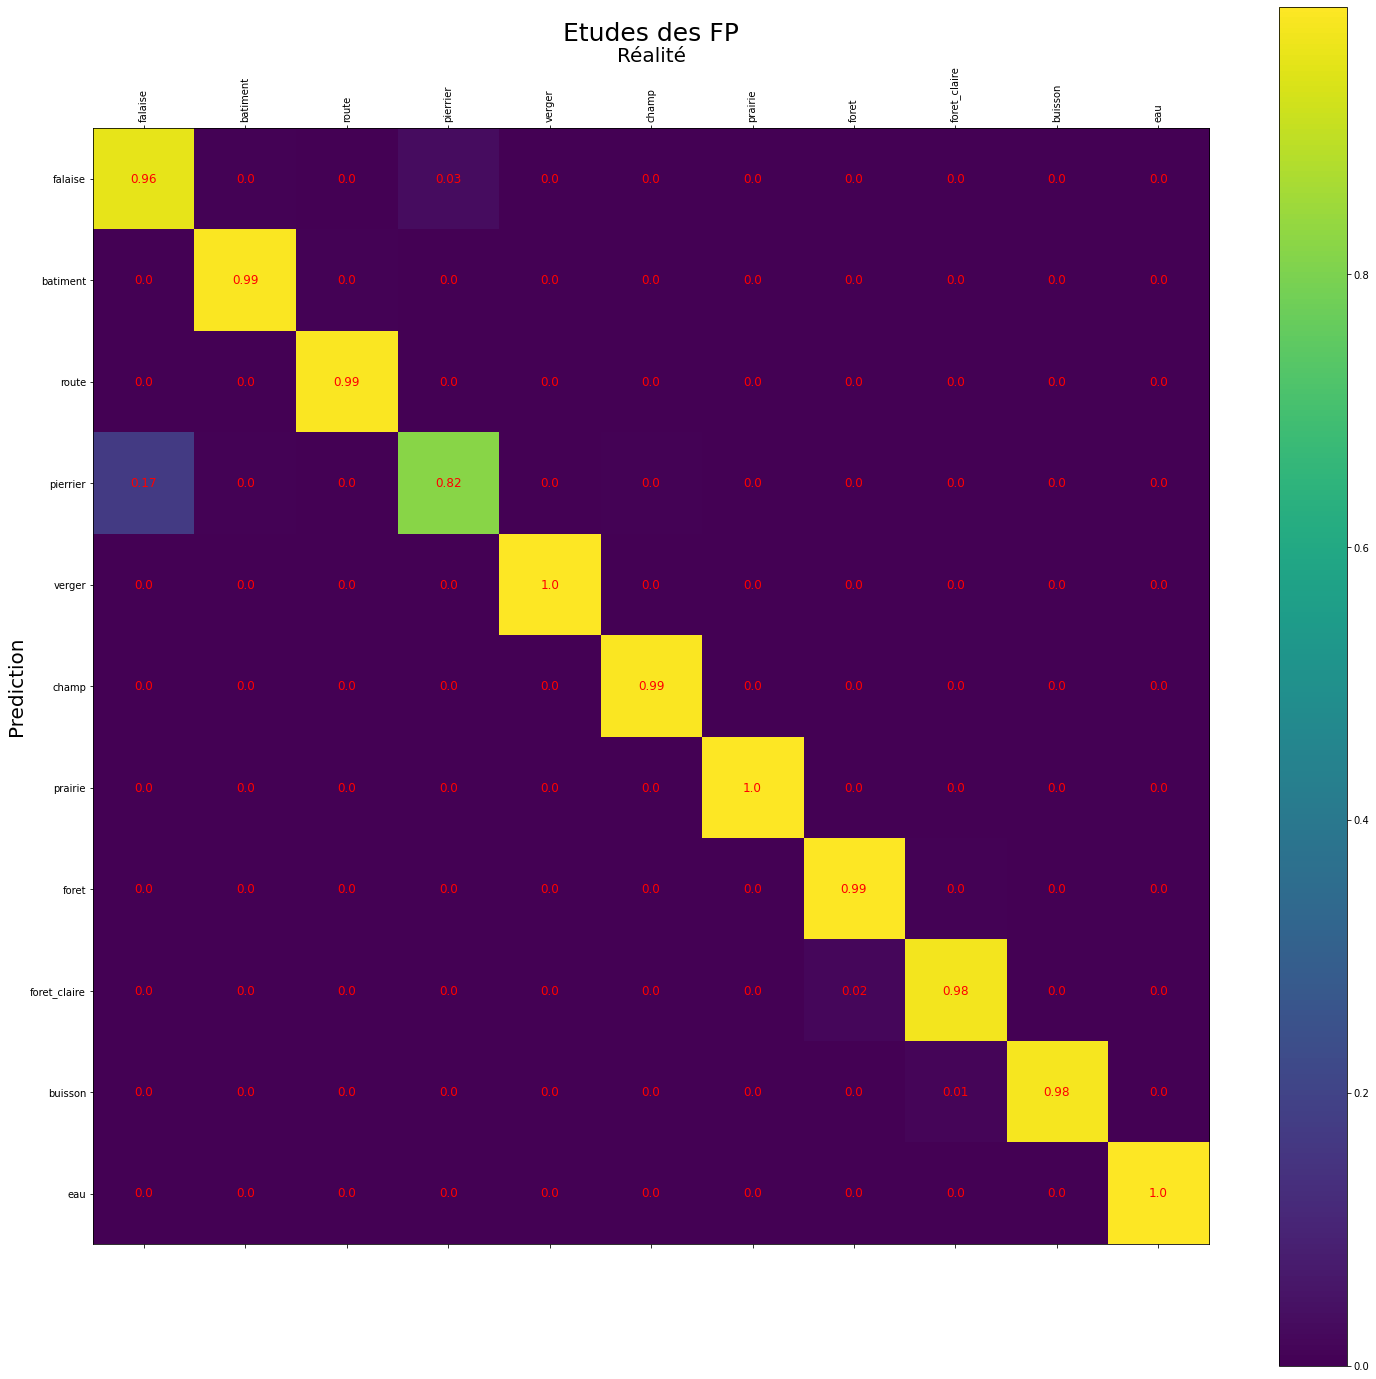

In [20]:
conf_mat_norm = conf_mat.T/conf_mat.sum(axis=1)

conf_mat_norm = conf_mat_norm.T

data = conf_mat_norm

fig = plt.figure(figsize=(25,25))
ax = fig.add_subplot(111)
cax = ax.matshow(data, interpolation='nearest')
fig.colorbar(cax)

for i in range(len(data)):
    for j in range(len(data)):
        c = data[j,i]
        ax.text(i, j, str(round(c,2)), va='center', ha='center',
                color="red",size = "large")
        
plt.xticks(range(11), classe, rotation='vertical')
plt.yticks(range(11), classe, rotation='horizontal')
plt.xlabel('Réalité', fontsize=20)
plt.gca().xaxis.set_label_position('top') 
plt.ylabel('Prediction', fontsize=20)
plt.gca().set_title("Etudes des FP", fontsize=25)
plt.show()
plt.show()

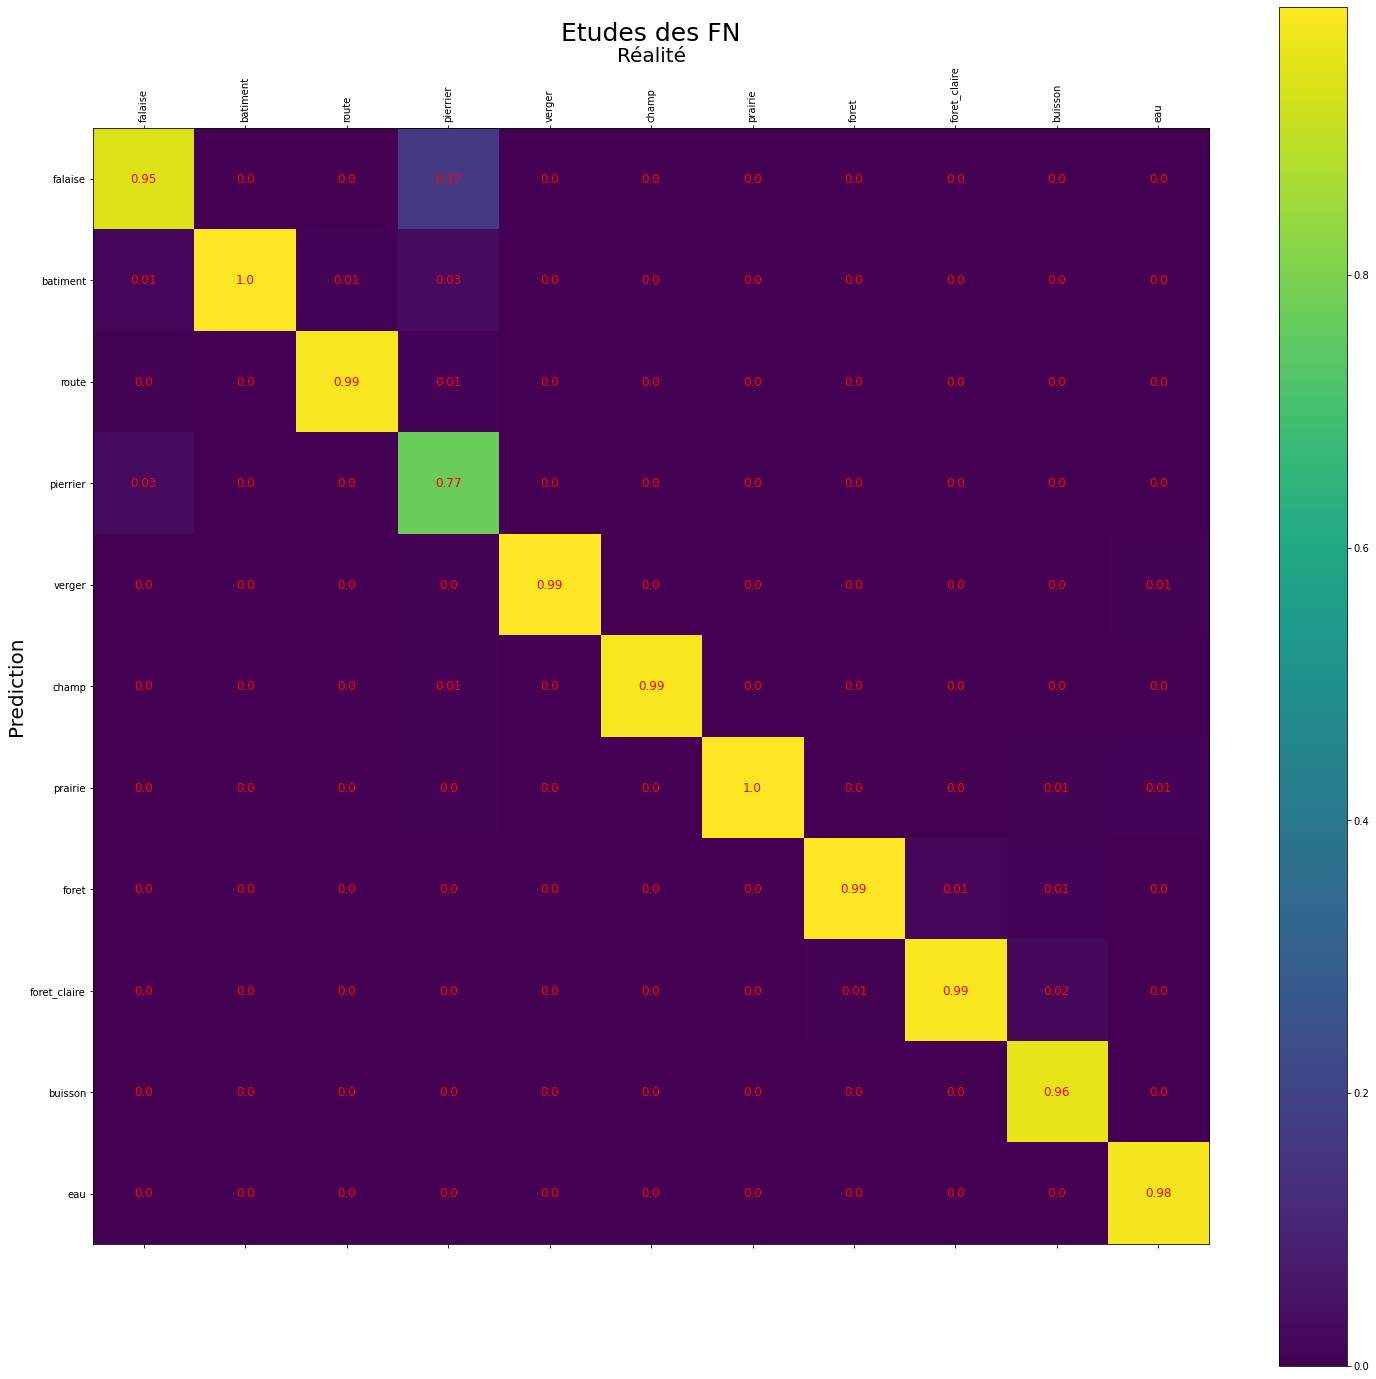

In [21]:
conf_mat_norm_bis = conf_mat / conf_mat.sum(axis=0)

data = conf_mat_norm_bis

fig = plt.figure(figsize=(25,25))
ax = fig.add_subplot(111)
cax = ax.matshow(data, interpolation='nearest')
fig.colorbar(cax)

for i in range(len(data)):
    for j in range(len(data)):
        c = data[j,i]
        ax.text(i, j, str(round(c,2)), va='center', ha='center',
                color="red",size = "large")
        
plt.xticks(range(11), classe, rotation='vertical')
plt.yticks(range(11), classe, rotation='horizontal')
plt.xlabel('Réalité', fontsize=20)
plt.gca().xaxis.set_label_position('top') 
plt.ylabel('Prediction', fontsize=20)
plt.gca().set_title("Etudes des FN", fontsize=25)
plt.show()
plt.show()

In [22]:
for idx_classe in range(11):
        prediction = np.where(predictions[...,idx_classe]<= threshold,0,1)
        target = valid_labels[...,idx_classe]

        intersection = np.logical_and(target,prediction)
        union = np.logical_or(target,prediction)
        iou_score = np.sum(intersection) / np.sum(union)
        dice_score = 2*iou_score / (iou_score +1)
        
        print("dice score for class", classes[idx_classe], ": with 0.2 threshold ",dice_score)


NameError: name 'threshold' is not defined

In [23]:
dico = {}
for key in classes:
    precision = conf_mat[key,key]/np.sum(conf_mat[key,:])
    recall = conf_mat[key,key]/np.sum(conf_mat[:,key])
    f1score = 2 * precision * recall /(precision + recall)
    dico[classes[key]] = {"precision":precision,"recall":recall,"f1":f1score}
    
dico

{'falaise': {'precision': 0.9591681200326211,
  'recall': 0.9453137099884499,
  'f1': 0.9521905221229148},
 'batiment': {'precision': 0.9899926661646443,
  'recall': 0.9965194500480534,
  'f1': 0.9932453360705976},
 'route': {'precision': 0.9887675582502986,
  'recall': 0.9850244741846156,
  'f1': 0.9868924670395061},
 'pierrier': {'precision': 0.8171716340729598,
  'recall': 0.7728298321662777,
  'f1': 0.794382433250694},
 'verger': {'precision': 0.9956354326767921,
  'recall': 0.9945899020938743,
  'f1': 0.995112392759596},
 'champ': {'precision': 0.9910725429727424,
  'recall': 0.9881752193341807,
  'f1': 0.9896217605285387},
 'prairie': {'precision': 0.9960849917809262,
  'recall': 0.9951052147918699,
  'f1': 0.9955948622338493},
 'foret': {'precision': 0.9929049778847968,
  'recall': 0.9935712948348974,
  'f1': 0.993238024609638},
 'foret_claire': {'precision': 0.9782043710956979,
  'recall': 0.9851892217713191,
  'f1': 0.9816843719916803},
 'buisson': {'precision': 0.983817683138

In [24]:
sommef1,sommerecall,sommeprecision = 0,0,0
for key in dico:
    sommef1 += dico[key]["f1"]
    sommerecall += dico[key]["recall"]
    sommeprecision += dico[key]["precision"]
    
print("mean f1 score is:" ,sommef1/len(dico))
print("mean precision score is:" ,sommeprecision/len(dico))
print("mean recall score is:" ,sommerecall/len(dico))

mean f1 score is: 0.9675316177238091
mean precision score is: 0.9716767991132884
mean recall score is: 0.9635473599288088


## Modèle entrainé sur le jeu de synthese testé sur le Jeu de validation Réelle

In [8]:
real_dir = "Real/Valid/"

x_valid_dir = os.path.join(real_dir, 'images')
y_valid_dir = os.path.join(real_dir, 'masks')

# Dataset for validation images
valid_dataset_real = Dataset(
    x_valid_dir, 
    y_valid_dir, 
    classes=12, 
    augmentation=False,
    preprocessing=get_preprocessing(preprocess_input),
    #preprocessing=False,
)

In [9]:
model.load_weights(os.path.join(result_dir,'best_model.h5'))

In [10]:
valid_imgs_real =[]
valid_labels_real =[]

for img,label in valid_dataset_real:
    valid_imgs_real.append(img)
    valid_labels_real.append(label)
    
valid_imgs_real = np.array(valid_imgs_real)
valid_labels_real = np.array(valid_labels_real)


In [11]:
predictions = model.predict(valid_imgs_real)

2/2 [==============================] - 19s 9s/step


In [19]:
classes_real = {0:"background",1:"buisson",2:"champ",3:"eau",
         4:"falaise",5:"foret",6:"foret_claire",
         7:"pierrier",8:"prairie",9:"route",10:"verger",
         11:"batiment"}

classes_syn = {0: "falaise" , 1: "batiment", 2:"route",3:"pierrier",4:"verger",
            5:"champ",6:"prairie",7:"foret",8:"foret_claire",9:"buisson",10:"eau"}

correspondance = {1:9,2:5,3:10,4:0,5:7,6:8,7:3,8:6,9:2,10:4,11:1}

In [13]:
valid_labels_real.shape,predictions.shape

((64, 512, 512, 12), (64, 512, 512, 11))

In [14]:
true_label = np.argmax(valid_labels_real,axis=3)
label_pred = np.argmax(predictions,axis=3)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


13


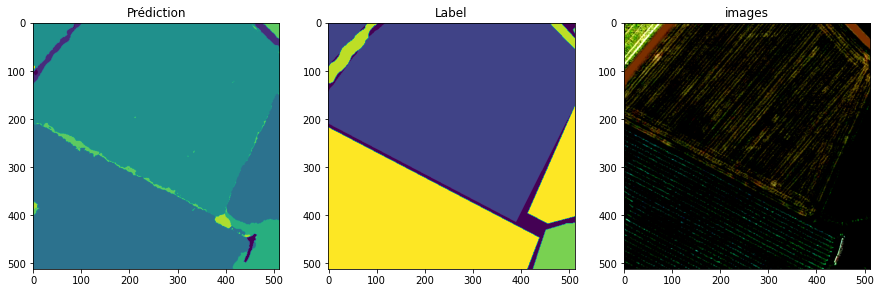

In [15]:
i=random.choice(range(len(valid_imgs_real)-1))
#i = 48
print(i)

plt.figure(figsize=(15, 5))
plt.subplot(131)
plt.imshow(label_pred[i])
plt.gca().set_title("Prédiction")

plt.subplot(132)
plt.imshow(true_label[i])
plt.gca().set_title("Label")

plt.subplot(133)
plt.imshow(valid_imgs_real[i])
plt.gca().set_title("images")
plt.show()

In [16]:
prediction = np.zeros(predictions.shape)

for idx_class in range(11):
    prediction[...,idx_class][label_pred == idx_class] = 1

In [22]:
a

['buisson',
 'champ',
 'eau',
 'falaise',
 'foret',
 'foret_claire',
 'pierrier',
 'prairie',
 'route',
 'verger',
 'batiment']

In [24]:
iou = {}

a = list(classes_real.values())

for idx_classe in range(1,12):
    # doesn't take into account background class since it is not present
    # in the synthese dataset
    target = valid_labels_real[...,idx_classe]

    intersection = np.logical_and(target,prediction[...,correspondance[idx_classe]])
    union = np.logical_or(target,prediction[...,correspondance[idx_classe]])
    iou_score = np.sum(intersection) / np.sum(union)
    iou[a[idx_classe]] = iou_score
print(iou)
    
print("mIou: ", np.mean(list(iou.values())))

{'buisson': 0.4491762597649296, 'champ': 0.5723926841109096, 'eau': 0.8123248480594992, 'falaise': 0.20074220558242414, 'foret': 0.6108372859525856, 'foret_claire': 0.3453631032235929, 'pierrier': 0.19539214012393416, 'prairie': 0.5492557212887199, 'route': 0.2265746885024277, 'verger': 0.7932954789244375, 'batiment': 0.22094326595985544}
mIou:  0.45239069831757417


In [19]:
conf_mat = np.zeros((11,12))

for idx_pred_class in range(1,12):
    for idx_target_class in range(0,12):
        target = valid_labels_real[...,idx_target_class]
        
        intersection = np.logical_and(target,prediction[...,correspondance[idx_pred_class]])
        conf_mat[idx_pred_class-1,idx_target_class] = np.sum(intersection)

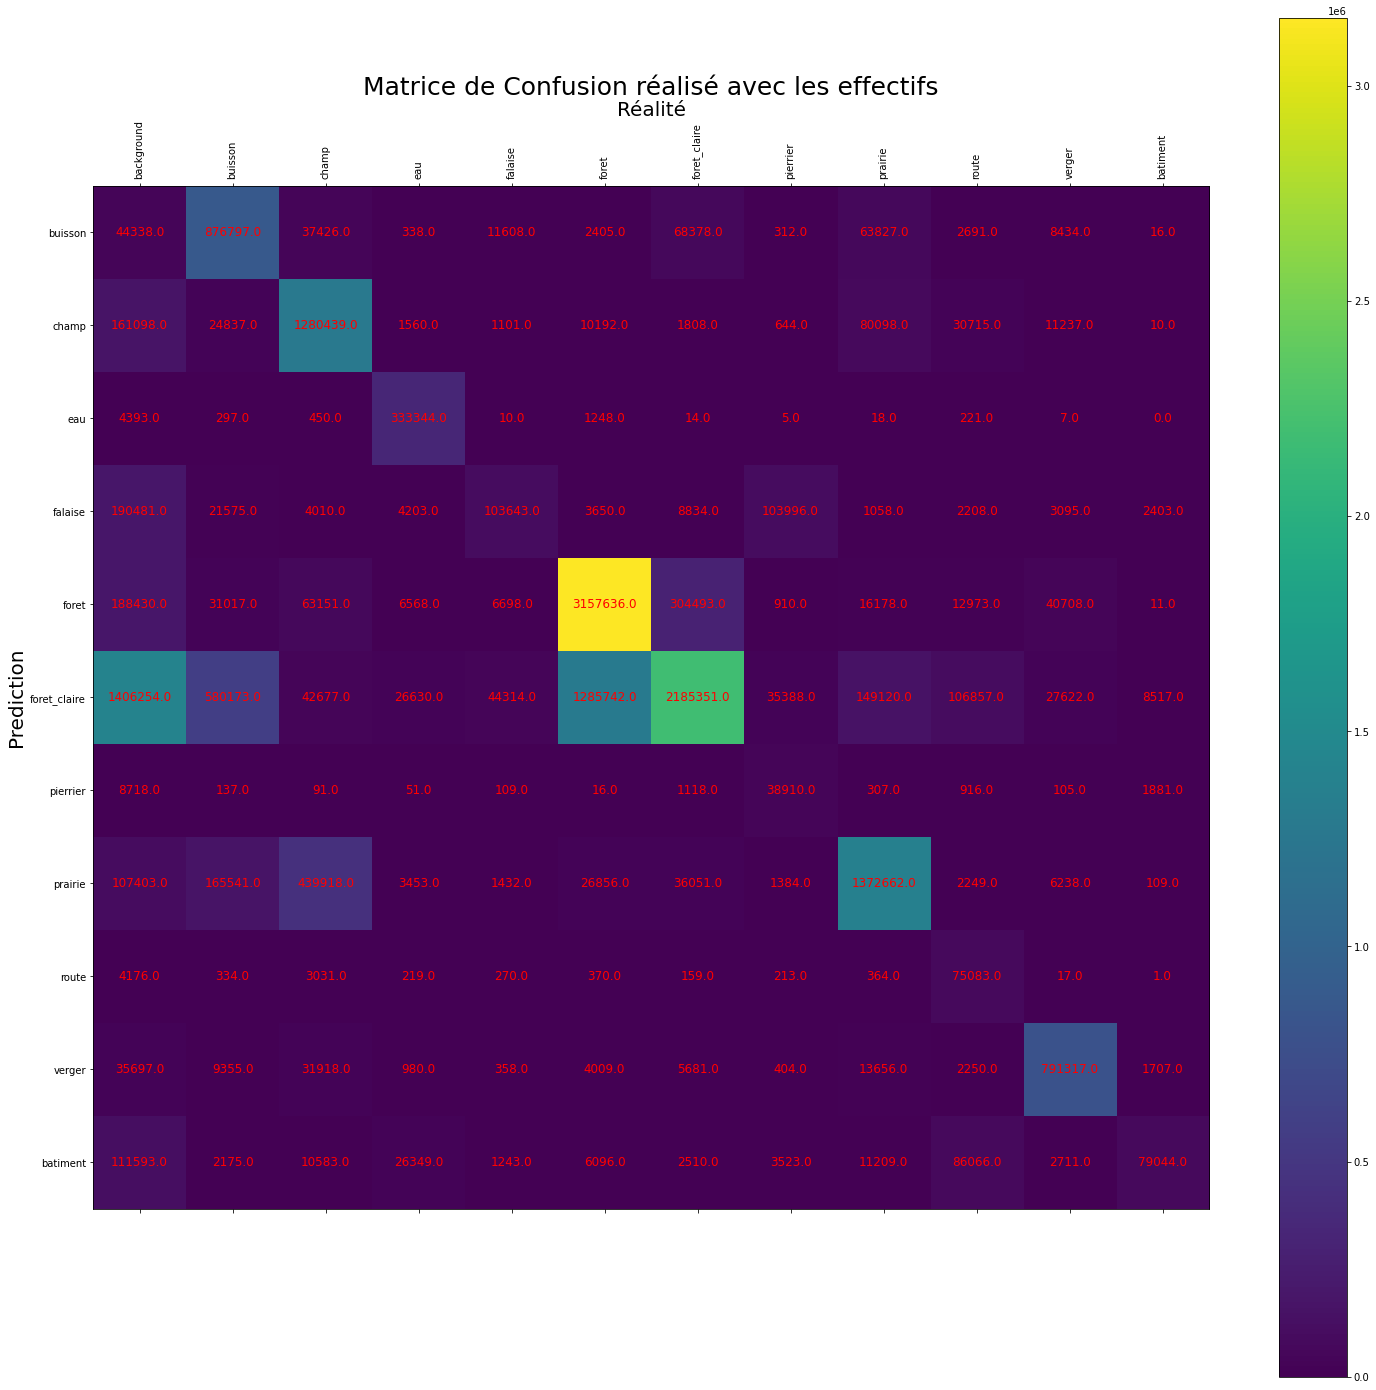

In [20]:
data = conf_mat

fig = plt.figure(figsize=(25,25))
ax = fig.add_subplot(111)
cax = ax.matshow(data, interpolation='nearest')
fig.colorbar(cax)

for i in range(len(data)+1):
    for j in range(len(data)):
        c = data[j,i]
        ax.text(i, j, str(round(c,2)), va='center', ha='center',
                color="red",size = "large")
        
plt.xticks(range(12), list(classes_real.values()), rotation='vertical')
plt.yticks(range(11), list(classes_real.values())[1:], rotation='horizontal')
plt.xlabel('Réalité', fontsize=20)
plt.gca().xaxis.set_label_position('top') 
plt.ylabel('Prediction', fontsize=20)
plt.gca().set_title("Matrice de Confusion réalisé avec les effectifs", fontsize=25)
plt.show()

In [21]:
assert np.sum(conf_mat.flatten())/len(label_pred.flatten()) == 1

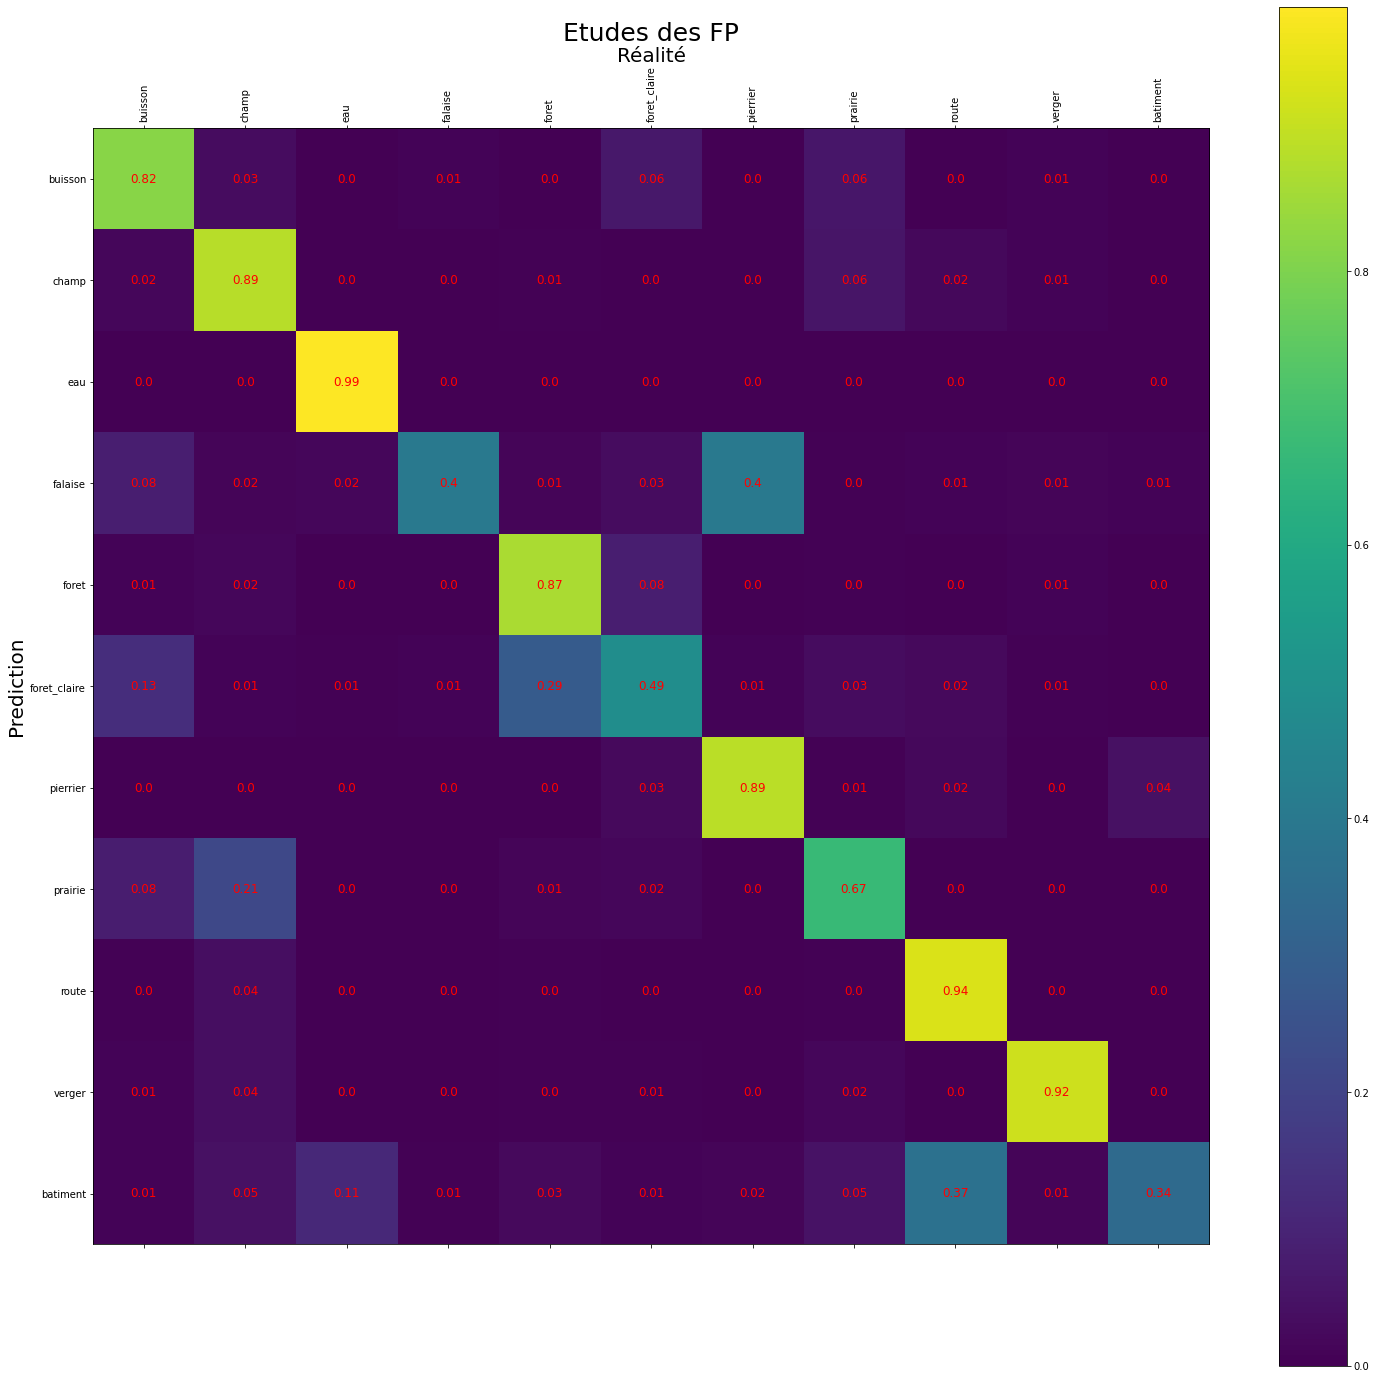

In [22]:
conf_mat_norm = conf_mat[:,1:].T/conf_mat[:,1:].sum(axis=1)

conf_mat_norm = conf_mat_norm.T

data = conf_mat_norm

fig = plt.figure(figsize=(25,25))
ax = fig.add_subplot(111)
cax = ax.matshow(data, interpolation='nearest')
fig.colorbar(cax)

for i in range(len(data)):
    for j in range(len(data)):
        c = data[j,i]
        ax.text(i, j, str(round(c,2)), va='center', ha='center',
                color="red",size = "large")
        
plt.xticks(range(11), list(classes_real.values())[1:], rotation='vertical')
plt.yticks(range(11), list(classes_real.values())[1:], rotation='horizontal')
plt.xlabel('Réalité', fontsize=20)
plt.gca().xaxis.set_label_position('top') 
plt.ylabel('Prediction', fontsize=20)
plt.gca().set_title("Etudes des FP", fontsize=25)
plt.show()

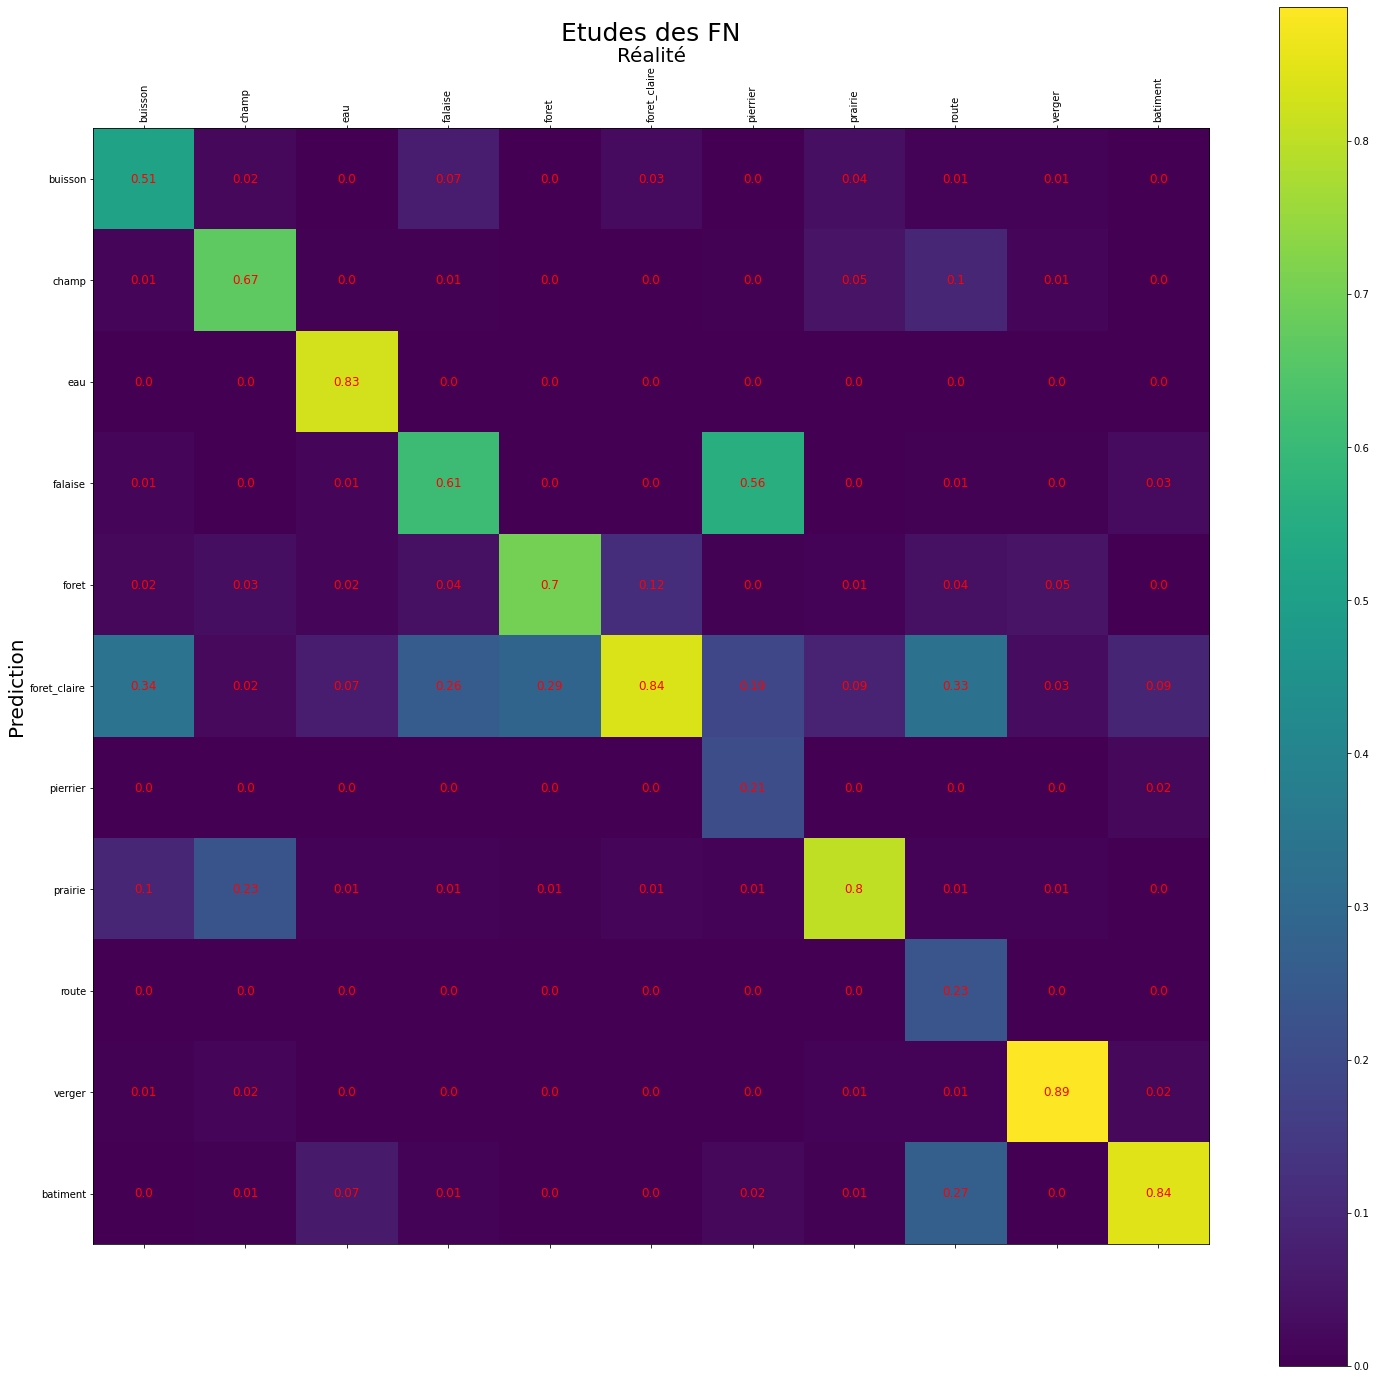

In [23]:
conf_mat_norm_bis = conf_mat[:,1:] / conf_mat[:,1:].sum(axis=0)

data = conf_mat_norm_bis

fig = plt.figure(figsize=(25,25))
ax = fig.add_subplot(111)
cax = ax.matshow(data, interpolation='nearest')
fig.colorbar(cax)

for i in range(11):
    for j in range(11):
        c = data[j,i]
        ax.text(i, j, str(round(c,2)), va='center', ha='center',
                color="red",size = "large")
        
plt.xticks(range(11), list(classes_real.values())[1:], rotation='vertical')
plt.yticks(range(11), list(classes_real.values())[1:], rotation='horizontal')
plt.xlabel('Réalité', fontsize=20)
plt.gca().xaxis.set_label_position('top') 
plt.ylabel('Prediction', fontsize=20)
plt.gca().set_title("Etudes des FN", fontsize=25)
plt.show()

In [24]:
conf_mat_without_background = conf_mat[:,1:]
conf_mat_without_background.shape

(11, 11)

In [25]:
dico = {}
for key in range(11):
    precision = conf_mat_without_background[key,key]/np.sum(conf_mat_without_background[key,:])
    recall = conf_mat_without_background[key,key]/np.sum(conf_mat_without_background[:,key])
    f1score = 2 * precision * recall /(precision + recall)
    dico[classes_real[key+1]] = {"precision":precision,"recall":recall,"f1":f1score}
    
dico

{'buisson': {'precision': 0.8177306776891569,
  'recall': 0.512076592155997,
  'f1': 0.6297765822580239},
 'champ': {'precision': 0.8875659294308147,
  'recall': 0.6690928643764363,
  'f1': 0.7629983300236716},
 'eau': {'precision': 0.993236277390097,
  'recall': 0.8257322978981657,
  'f1': 0.9017717896035352},
 'falaise': {'precision': 0.4006687928868271,
  'recall': 0.6068588760202827,
  'f1': 0.48266548068392706},
 'foret': {'precision': 0.8674006817489451,
  'recall': 0.701974558825491,
  'f1': 0.7759689271926752},
 'foret_claire': {'precision': 0.4864560987678944,
  'recall': 0.83589102955672,
  'f1': 0.6150038526546733},
 'pierrier': {'precision': 0.8915927682683715,
  'recall': 0.20954391482532622,
  'f1': 0.3393363275629006},
 'prairie': {'precision': 0.6676719070496373,
  'recall': 0.8034324906628457,
  'f1': 0.7292878793111236},
 'route': {'precision': 0.9378224104120608,
  'recall': 0.233011305624261,
  'f1': 0.3732779835442094},
 'verger': {'precision': 0.9183900375449001,


In [26]:
sommef1,sommerecall,sommeprecision = 0,0,0
for key in dico:
    sommef1 += dico[key]["f1"]
    sommerecall += dico[key]["recall"]
    sommeprecision += dico[key]["precision"]
    
print("mean f1 score is:" ,sommef1/len(dico))
print("mean precision score is:" ,sommeprecision/len(dico))
print("mean recall score is:" ,sommerecall/len(dico))

mean f1 score is: 0.6362682156699279
mean precision score is: 0.7463604610955301
mean recall score is: 0.6480765486700606
